In [ ]:
!nvidia-smi

Thu Sep  7 03:22:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q numpy
!pip install -q matplotlib
!pip install -q pandas
!pip install -q tensorflow
!pip install -q scikit-learn
!pip install -q pandas-datareader
!pip install -q yfinance
!pip install --upgrade mplfinance

# Code Source Note: https://github.com/twopirllc/pandas-ta
!pip install -q pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive/')

# Set the working directory for the tasks
SKELETON_DIR = '/content/drive/MyDrive/stock-prediction/MachineLearning1'
os.chdir(SKELETON_DIR)

Mounted at /content/drive/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import yfinance as yf
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, SimpleRNN, GRU, InputLayer, Input, Activation
from tensorflow.keras.utils import plot_model

import joblib

In [ ]:
start='2015-01-01'
end='2023-09-07'
ticker='TSLA'

# Price Value
price_value = 'Close' # This can be change to 'Open', 'Close', 'Adj Close , 'High', 'Low'

# Split Dataset for Training/Testing
split_ratio=0.8

# Number of look back days to base the prediction
step_size = 30 # Can be changed

# Directory
DATA_DIR = os.path.join(SKELETON_DIR, "data")
PREPARED_DATA_DIR = os.path.join(SKELETON_DIR, "prepared-data")

# File Path
CSV_FILE = os.path.join(DATA_DIR, f"RawData-from-{start}to-{end}-{ticker}_stock_data.csv")
PREPARED_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"PreparedData-from-{start}to-{end}-{ticker}_stock_data.csv")
PREPARED_TRAIN = os.path.join(PREPARED_DATA_DIR, f"{ticker}_xytrain-from-{start}to-{end}-{ticker}_prepared_data.npz")
TRAIN_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"TrainData-from-{start}to-{end}-{ticker}_stock_data.csv")
TEST_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"TestData-from-{start}to-{end}-{ticker}_stock_data.csv")
SCALER_FEATURE_FILE = os.path.join(PREPARED_DATA_DIR, f"FeatureScaler-from-{start}to-{end}-{ticker}.pkl")
SCALER_TARGET_FILE = os.path.join(PREPARED_DATA_DIR, f"TargetScaler-from-{start}to-{end}-{ticker}.pkl")
TRAIN_ARRAY_FILE = os.path.join(PREPARED_DATA_DIR, f"{ticker}_xytrain-from-{start}to-{end}_train_arrays.npz")
TEST_ARRAY_FILE = os.path.join(PREPARED_DATA_DIR, f"{ticker}_xytrain-from-{start}to-{end}_test_arrays.npz")

In [ ]:
# Double check directory
def ensure_directory_exists(dir_path):
  # If directory not exist => create
  if not os.path.isdir(dir_path):
      os.mkdir(dir_path)

In [ ]:
# Save and Load utility functions
def save_object(obj, filename):
    with open(filename, 'wb') as f:
        joblib.dump(obj, f)

def load_object(filename):
    with open(filename, 'rb') as f:
        return joblib.load(f)

In [ ]:
# Load Raw Data
def load_data(start, end, ticker, source='yahoo'):
  ensure_directory_exists(DATA_DIR)

  # Check if CSV file exists
  # If exist => load
  # If not exist => download
  if os.path.exists(CSV_FILE):
      print('Loading Existing Data')
      data = pd.read_csv(CSV_FILE)
  else:
      print('Downloading Data')
      data = yf.download(ticker, start, end, progress=False)
      data.to_csv(CSV_FILE)

  return data

In [ ]:
# Data Validation
def data_validation(start, end, ticker):
  ensure_directory_exists(PREPARED_DATA_DIR)


  if os.path.exists(PREPARED_DATA_FILE):
      print('Loading Prepared Data')
      df = pd.read_csv(PREPARED_DATA_FILE)
  else:
      print('Processing Raw Data')

      # Read Raw Data File
      df = pd.read_csv(CSV_FILE)

      df['Date'] = pd.to_datetime(df['Date'])

      df.set_index('Date', inplace=True)

      # Adding indicators
      df['RSI']=ta.rsi(df.Close, length=15)
      df['EMAF']=ta.ema(df.Close, length=20)
      df['EMAM']=ta.ema(df.Close, length=100)
      df['EMAS']=ta.ema(df.Close, length=150)

      df['Target'] = df['Adj Close']-df.Open
      df['Target'] = df['Target'].shift(-1)

      df['TargetClass'] = [1 if df.Target[i]>0 else 0 for i in range(len(df))]

      df['TargetNextClose'] = df['Adj Close'].shift(-1)

      # Drop NaN issue in data
      df.dropna(inplace=True)

      # Drop Columns
      # df.drop(['Volume','Close', 'Date'], axis=1, inplace=True)

      # Export Prepared Data
      df.to_csv(PREPARED_DATA_FILE)

  return df

In [ ]:
# Split Data by Date or Randomly
def split_data(df, split_ratio, split_by_date=True):
    if split_by_date:
        # Split by date
        train_size = int(len(df) * split_ratio)
        train_data = df.iloc[:train_size]
        test_data = df.iloc[train_size:]
    else:
        # Split Randomly
        train_data, test_data = train_test_split(df, test_size=1-split_ratio, random_state=42)

    print(f"Train Data Shape: {train_data.shape}")
    print(f"Test Data Shape: {test_data.shape}")

    return train_data, test_data


In [ ]:
# Scaler
def scaler_features(input_data, scale=True):
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Reshaping if input_data is a Series or 1D numpy array
        if len(input_data.shape) == 1:
            input_data = input_data.values.reshape(-1, 1)

        scaled_data = scaler.fit_transform(input_data)
        return scaled_data, scaler
    else:
        return input_data, None


In [ ]:
def create_datasets(start, end, ticker):

    # Download or Load Raw Data
    data = load_data(start, end, ticker)

    # Data Validation
    df = data_validation(start, end, ticker)

    if os.path.exists(TRAIN_DATA_FILE) and os.path.exists(TEST_DATA_FILE):
        print('Loading Existing Train and Test Data')
        train_data = pd.read_csv(TRAIN_DATA_FILE)
        test_data = pd.read_csv(TEST_DATA_FILE)

        print(f"Train Data Shape: {train_data.shape}")
        print(f"Test Data Shape: {test_data.shape}")

        # Load feature and target scalers
        train_feature_scaler = load_object(SCALER_FEATURE_FILE)
        train_target_scaler = load_object(SCALER_TARGET_FILE)

        # Load x_train, y_train, x_test, y_test
        train_arrays = np.load(TRAIN_ARRAY_FILE)
        x_train = train_arrays['x_train']
        y_train = train_arrays['y_train']

        test_arrays = np.load(TEST_ARRAY_FILE)
        x_test = test_arrays['x_test']
        y_test = test_arrays['y_test']

    else:
        print('Processing Train and Test Data')
        # Split Data
        train_data, test_data = split_data(df, split_ratio)

        # Define features and target
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI', 'EMAF', 'EMAM', 'EMAS']
        target_column = 'TargetNextClose'

        # Preparing Train Datasets
        # Scaler for features
        scaled_data_train, train_feature_scaler = scaler_features(train_data[feature_columns])
        # Scaler for target
        scaled_target_train, train_target_scaler = scaler_features(train_data[target_column].values.reshape(-1, 1))

        x_train, y_train = [], []
        for i in range(step_size, len(scaled_data_train)):
            x_train.append(scaled_data_train[i-step_size:i])
            y_train.append(scaled_target_train[i])

        x_train, y_train = np.array(x_train), np.array(y_train)

        # Preparing Test Datasets
        # Use the feature scaler to scale the test data
        scaled_data_test = train_feature_scaler.transform(test_data[feature_columns])
        # Use the target scaler to scale the test target
        scaled_target_test = train_target_scaler.transform(test_data[target_column].values.reshape(-1, 1))

        x_test, y_test = [], []
        for i in range(step_size, len(scaled_data_test)):
            x_test.append(scaled_data_test[i-step_size:i])
            y_test.append(scaled_target_test[i])

        x_test, y_test = np.array(x_test), np.array(y_test)

        # Save train_data and test_data
        train_data.to_csv(TRAIN_DATA_FILE)
        test_data.to_csv(TEST_DATA_FILE)

        # Save feature and target scalers
        save_object(train_feature_scaler, SCALER_FEATURE_FILE)
        save_object(train_target_scaler, SCALER_TARGET_FILE)

        # Save x_train, y_train, x_test, y_test
        np.savez(TRAIN_ARRAY_FILE, x_train=x_train, y_train=y_train)

        np.savez(TEST_ARRAY_FILE, x_test=x_test, y_test=y_test)

    # For data
    if not isinstance(data.index, pd.DatetimeIndex):
        if "Date" in data.columns:
            data['Date'] = pd.to_datetime(data['Date'])
            data.set_index('Date', inplace=True)

    # For df
    if not isinstance(df.index, pd.DatetimeIndex):
        if "Date" in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)

    # For train_data
    if not isinstance(train_data.index, pd.DatetimeIndex):
        if "Date" in train_data.columns:
            train_data['Date'] = pd.to_datetime(train_data['Date'])
            train_data.set_index('Date', inplace=True)

    # For test_data
    if not isinstance(test_data.index, pd.DatetimeIndex):
        if "Date" in test_data.columns:
            test_data['Date'] = pd.to_datetime(test_data['Date'])
            test_data.set_index('Date', inplace=True)


    return data, df, train_data, test_data, train_feature_scaler, train_target_scaler, x_train, x_test, y_train, y_test


In [ ]:
data, df, train_data, test_data, train_feature_scaler, train_target_scaler, x_train, x_test, y_train, y_test = create_datasets(start, end, ticker)

Processing Raw Data
Processing Train and Test Data
Train Data Shape: (1627, 13)
Test Data Shape: (407, 13)


In [ ]:
print("Data shapes/types:")
print("data:", type(data))
print("df:", type(df))
print("train_data:", train_data.shape)
print("test_data:", test_data.shape)
print("train_feature_scaler:", type(train_feature_scaler))
print("train_target_scaler:", type(train_target_scaler))
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Data shapes/types:
data: <class 'pandas.core.frame.DataFrame'>
df: <class 'pandas.core.frame.DataFrame'>
train_data: (1627, 13)
test_data: (407, 13)
train_feature_scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
train_target_scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
x_train: (1597, 30, 10)
x_test: (377, 30, 10)
y_train: (1597, 1)
y_test: (377, 1)


In [ ]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500


In [ ]:
data.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600
2023-09-06,255.139999,255.389999,245.059998,251.919998,251.919998,116696300


In [ ]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-08-06,16.636000,17.000000,15.741333,16.408667,16.408667,219357000,40.237745,17.562829,16.245100,15.200760,-0.071333,0,16.167334
2015-08-07,16.238667,16.248667,15.892667,16.167334,16.167334,76101000,38.598500,17.429924,16.243561,15.213562,0.199333,1,16.076000
2015-08-10,15.876667,16.198000,15.736667,16.076000,16.076000,62788500,37.971249,17.300979,16.240243,15.224985,0.014667,1,15.824667


In [ ]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700,57.613197,244.661247,232.596473,225.801267,-12.250015,0,245.009995
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500,49.492845,244.694461,232.842285,226.055688,11.489990,1,256.489990
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600,55.407679,245.817845,233.310557,226.458791,-3.220001,0,251.919998


In [ ]:
train_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-08-06,16.636000,17.000000,15.741333,16.408667,16.408667,219357000,40.237745,17.562829,16.245100,15.200760,-0.071333,0,16.167334
2015-08-07,16.238667,16.248667,15.892667,16.167334,16.167334,76101000,38.598500,17.429924,16.243561,15.213562,0.199333,1,16.076000
2015-08-10,15.876667,16.198000,15.736667,16.076000,16.076000,62788500,37.971249,17.300979,16.240243,15.224985,0.014667,1,15.824667


In [ ]:
train_data.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-01-18,342.203339,356.929993,338.686676,343.503326,343.503326,66743400,47.773035,352.389700,320.618059,300.328648,-15.353333,0,331.883331
2022-01-19,347.236664,351.556671,331.666656,331.883331,331.883331,75442500,44.660152,350.436713,320.841134,300.746591,-4.486664,0,332.089996
2022-01-20,336.576660,347.220001,331.333344,332.089996,332.089996,70488600,44.728781,348.689407,321.063884,301.161735,-17.480011,0,314.633331


In [ ]:
test_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-01-21,332.113342,334.850006,313.500000,314.633331,314.633331,103416000,40.215277,345.445971,320.936546,301.340167,8.413330,1,310.000000
2022-01-24,301.586670,311.170013,283.823334,310.000000,310.000000,151565700,39.093450,342.070164,320.719981,301.454867,1.399994,1,306.133331
2022-01-25,304.733337,317.086670,301.070007,306.133331,306.133331,86595900,38.142087,338.647609,320.431136,301.516833,-5.006653,0,312.470001


In [ ]:
test_data.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700,57.613197,244.661247,232.596473,225.801267,-12.250015,0,245.009995
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500,49.492845,244.694461,232.842285,226.055688,11.489990,1,256.489990
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600,55.407679,245.817845,233.310557,226.458791,-3.220001,0,251.919998


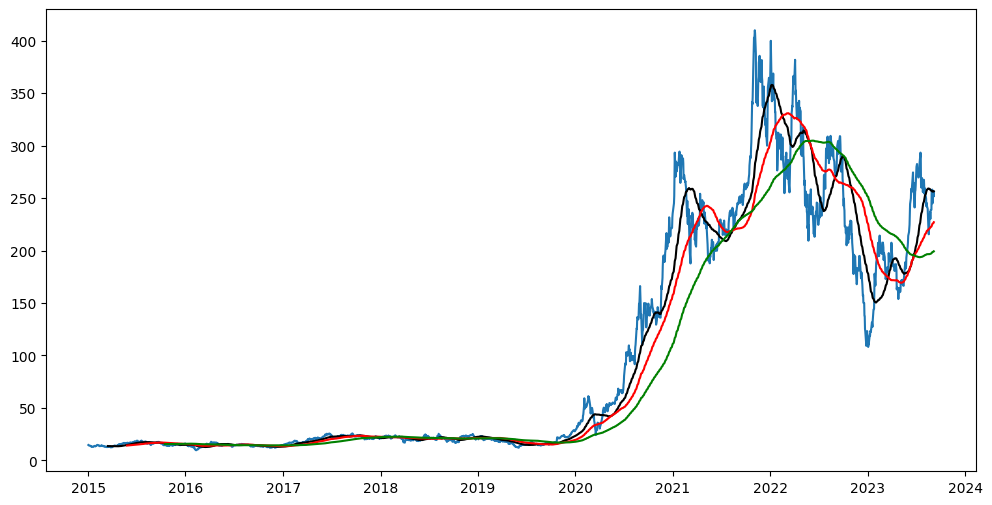

In [ ]:
# Moving Avg
ma50 = data[price_value].rolling(50).mean()
ma100 = data[price_value].rolling(100).mean()
ma200 = data[price_value].rolling(200).mean()

# Plot Chart with MA
plt.figure(figsize=(12,6))
plt.plot(data.Close)
plt.plot(ma50, 'k')
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [ ]:
def plot_candlestick(input_df, n=1):

    # Copy to avoid warnings
    input_df = input_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        input_df = input_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    # Add moving averages to the dataframe
    input_df['MA50'] = input_df['Close'].rolling(window=50).mean()
    input_df['MA100'] = input_df['Close'].rolling(window=100).mean()
    input_df['MA200'] = input_df['Close'].rolling(window=200).mean()

    # Create a custom plot for the moving averages
    ap = []
    if input_df['MA50'].dropna().shape[0] > 0:
        aligned_MA50 = input_df['MA50'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA50, color='orange'))
    if input_df['MA100'].dropna().shape[0] > 0:
        aligned_MA100 = input_df['MA100'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA100, color='green'))
    if input_df['MA200'].dropna().shape[0] > 0:
        aligned_MA200 = input_df['MA200'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA200, color='magenta'))

    # Plot the candlestick chart
    mpf.plot(input_df, type='candle', style='charles',
             title=f"{ticker} Candlestick Chart",
             ylabel='Price',
             volume=True,
             ylabel_lower='Volume',
             addplot=ap,
             show_nontrading=True)

In [ ]:
def plot_boxplot(input_df, n=1, k=10):
    # Copy to avoid warnings
    input_df = input_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        input_df = input_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    # Prepare data for boxplot
    box_data = []
    labels = []
    for idx, row in input_df.iterrows():
        box_data.append([row['Low'], row['Open'], row['Close'], row['High']])
        labels.append(idx.strftime('%Y-%m-%d'))

    # Plotting
    fig, ax = plt.subplots()
    ax.boxplot(box_data, vert=True, patch_artist=True)
    ax.set_title(f'{ticker} Boxplot Chart')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Set x-axis labels and ticks
    ax.set_xticks(range(1, len(labels) + 1, k))
    ax.set_xticklabels(labels[::k], rotation=90)

    plt.show()

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


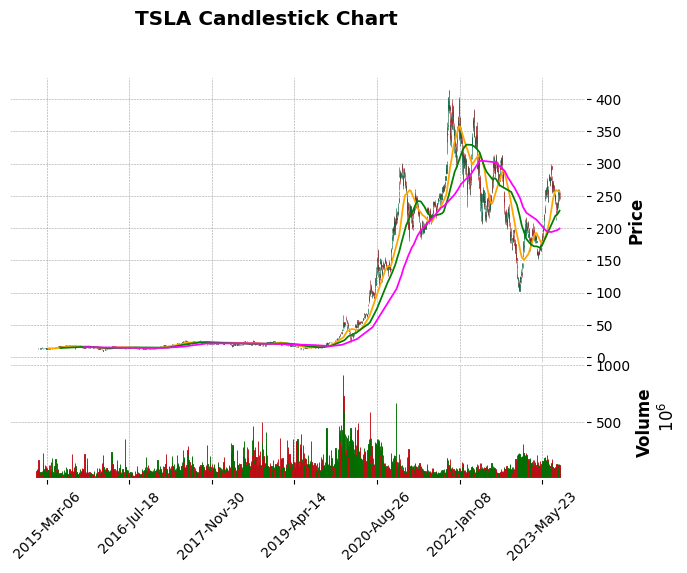

In [ ]:
plot_candlestick(data)

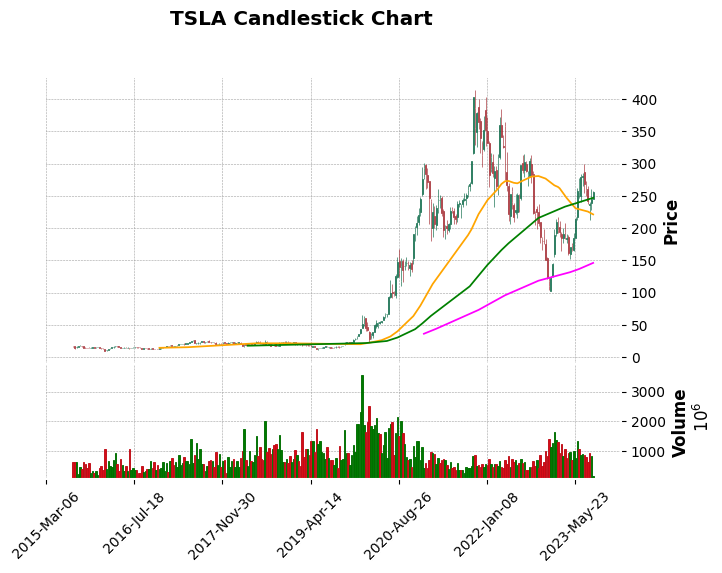

In [ ]:
plot_candlestick(df, n=10)

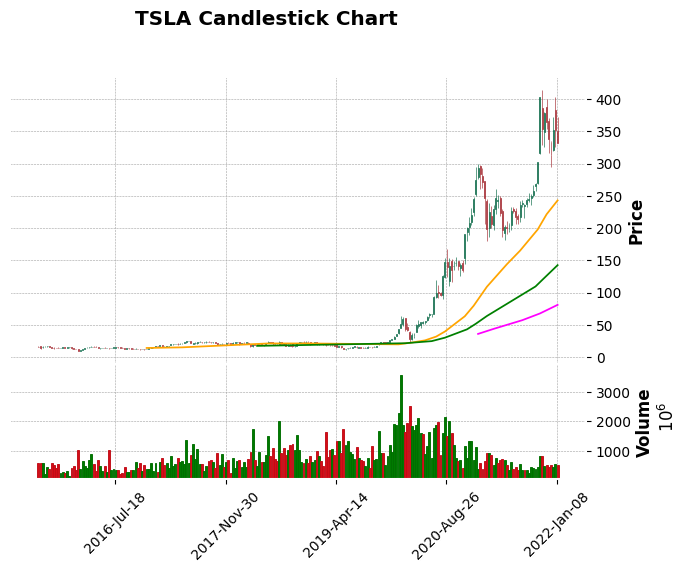

In [ ]:
plot_candlestick(train_data,n=10)

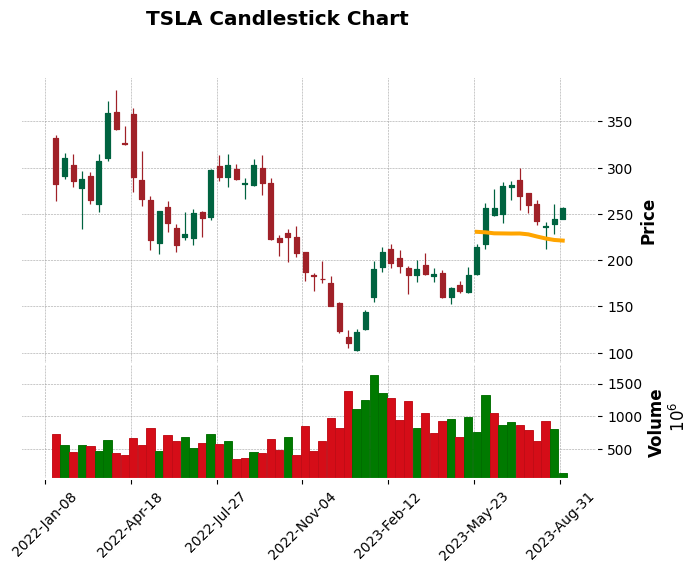

In [ ]:
plot_candlestick(test_data,n=10)

# create_dynamic_model

**The function `create_dynamic_model` takes the following parameters:**

1. `input_shape`: This parameter, a tuple, denotes the shape of the input data that will be fed into the neural network.

2. `layer_configs`: A list of dictionaries representing the configuration for each layer in the neural network. The configurations include details like the type of the layer (LSTM, GRU, RNN, etc.), the number of units, whether the layer should return sequences, activation function, and the dropout rate.

3. `output_units`: An optional parameter with a default value of 1. It indicates the number of units in the output layer of the neural network.

**This function exhibits the following characteristics:**

1. **Initialization of Sequential Model**: The function initiates a Sequential model which serves as the framework to which various layers will be added based on the configurations specified in `layer_configs`.

2. **First Layer Configuration**: The function configures the first layer based on the details provided in the first dictionary of `layer_configs`. It includes handling different types of layers (LSTM, GRU, and SimpleRNN) and potentially wrapping them with a Bidirectional layer. The input shape for this layer is specified by the `input_shape` parameter.

3. **Adding Activation and Dropout to First Layer**: If an activation function is specified in the configuration of the first layer, it is added following the layer. A dropout layer is then added with the specified dropout rate to prevent overfitting.

4. **Configuration of Subsequent Layers**: Following the first layer, the function iterates through the remaining configurations in `layer_configs` to add subsequent layers to the model. Similar to the first layer, these can be of different types (LSTM, GRU, SimpleRNN) and can be wrapped with a Bidirectional layer if specified. Activation functions and dropout layers are added as specified in each configuration.

5. **Output Layer Addition**: Finally, an output layer with the specified number of units (`output_units`) is added to the model to obtain the final output.

6. **Returning the Model**: After configuring and assembling all layers, the function returns the constructed Sequential model which can then be compiled and used for training with data.


In [ ]:
def create_dynamic_model(input_shape, layer_configs, output_units=1):
    model = Sequential()

    # First layer needs to specify input_shape
    first_layer_config = layer_configs[0]
    layer_type = first_layer_config['type']

    if 'Bidirectional' in layer_type:
        layer_type = layer_type.replace('Bidirectional(', '').replace(')', '')
        if layer_type == 'LSTM':
            model.add(Bidirectional(LSTM(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences']), input_shape=input_shape))
        elif layer_type == 'GRU':
            model.add(Bidirectional(GRU(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences']), input_shape=input_shape))
        elif layer_type == 'RNN':
            model.add(Bidirectional(SimpleRNN(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences']), input_shape=input_shape))
    else:
        if layer_type == 'LSTM':
            model.add(LSTM(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences'], input_shape=input_shape))
        elif layer_type == 'GRU':
            model.add(GRU(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences'], input_shape=input_shape))
        elif layer_type == 'RNN':
            model.add(SimpleRNN(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences'], input_shape=input_shape))

    if 'activation' in first_layer_config:
        model.add(Activation(first_layer_config['activation']))

    model.add(Dropout(first_layer_config['dropout']))

    # Remaining layers
    for layer_config in layer_configs[1:]:
        layer_type = layer_config['type']

        if 'Bidirectional' in layer_type:
            layer_type = layer_type.replace('Bidirectional(', '').replace(')', '')
            if layer_type == 'LSTM':
                model.add(Bidirectional(LSTM(units=layer_config['units'], return_sequences=layer_config['return_sequences']), input_shape=input_shape))
            elif layer_type == 'GRU':
                model.add(Bidirectional(GRU(units=layer_config['units'], return_sequences=layer_config['return_sequences']), input_shape=input_shape))
            elif layer_type == 'RNN':
                model.add(Bidirectional(SimpleRNN(units=layer_config['units'], return_sequences=layer_config['return_sequences']), input_shape=input_shape))
        else:
            if layer_type == 'LSTM':
                model.add(LSTM(units=layer_config['units'], return_sequences=layer_config['return_sequences']))
            elif layer_type == 'GRU':
                model.add(GRU(units=layer_config['units'], return_sequences=layer_config['return_sequences']))
            elif layer_type == 'RNN':
                model.add(SimpleRNN(units=layer_config['units'], return_sequences=layer_config['return_sequences']))

        if 'activation' in layer_config:
            model.add(Activation(layer_config['activation']))

        model.add(Dropout(layer_config['dropout']))

    # Output layer
    model.add(Dense(units=output_units))

    return model

# plot_metric

**The function `plot_metric` takes the following parameters:**

1. `metric_name_1`: A string representing the name of the first metric to be plotted. This name is used to retrieve the metric values from the `model_training_history.history` dictionary.

2. `metric_name_2`: Similarly, this is a string representing the name of the second metric to be plotted. The metric values are retrieved from the `model_training_history.history` dictionary.

3. `plot_name`: A string that will be used as the title of the plot, helping in identifying the graph.

**This function performs the following operations:**

1. **Fetching Metric Values**: Using the metric names specified by `metric_name_1` and `metric_name_2` as identifiers, the function fetches the metric values from the `model_training_history.history` dictionary.

2. **Epoch Range Calculation**: The function calculates the number of epochs by determining the length of the metric values list (obtained using `metric_name_1`). This range is used as the time or x-axis in the plot.

3. **Plotting the Graph**: Using matplotlib's plot function, it plots the metric values against the epoch range. The plot for `metric_name_1` is displayed in blue, and the plot for `metric_name_2` is displayed in red.

4. **Adding Title to the Plot**: It sets the title of the plot to the value specified by the `plot_name` parameter, assisting in identifying the content of the graph.

5. **Adding Legend to the Plot**: Finally, a legend is added to the plot, which helps in distinguishing between the two metric plots, with labels indicating which line corresponds to `metric_name_1` and which corresponds to `metric_name_2`.

**Note**: This function implicitly assumes the existence of a `model_training_history` variable and `plt` (from matplotlib.pyplot) in the scope where it is called.


In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

In [ ]:
n_steps = x_train.shape[1]
print(n_steps)
n_features = x_train.shape[2]
print(n_features)
input_shape = (n_steps, n_features)

30
10


In [ ]:
# Test 1 - Mix LSTM, GRU, RNN, Differs Activation
layer_configs = [
    { 'type': 'LSTM', 'units': 120, 'return_sequences': True, 'dropout': 0.25, 'activation': 'tanh' },
    { 'type': 'LSTM', 'units': 100, 'return_sequences': True, 'dropout': 0.25 },
    { 'type': 'GRU', 'units': 80, 'return_sequences': True, 'dropout': 0.25 },
    { 'type': 'RNN', 'units': 60, 'return_sequences': True, 'dropout': 0.25, 'activation': 'relu' },
    { 'type': 'LSTM', 'units': 40, 'return_sequences': False, 'dropout': 0.25 }
]

In [ ]:
# Test 2 - Simple LSTM Model
layer_configs = [
    { 'type': 'LSTM', 'units': 50, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'LSTM', 'units': 50, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 3 - Simple GRU Model (Most Accurate)
layer_configs = [
    { 'type': 'GRU', 'units': 100, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'GRU', 'units': 100, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 4 - More complex GRU Model
layer_configs = [
    { 'type': 'GRU', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'GRU', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'GRU', 'units': 128, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 5 - Mixed LSTM and GRU Model
layer_configs = [
    { 'type': 'LSTM', 'units': 100, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'GRU', 'units': 100, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 6 - Deep LSTM with more Units Model
layer_configs = [
    { 'type': 'LSTM', 'units': 200, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'LSTM', 'units': 150, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'LSTM', 'units': 100, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 7 - LTSM Reduced Dropout Model
layer_configs = [
    { 'type': 'LSTM', 'units': 100, 'return_sequences': True, 'dropout': 0.1 },
    { 'type': 'LSTM', 'units': 100, 'return_sequences': False, 'dropout': 0.1 }
]

In [ ]:
# Test 8 -  Complex Bidirectional LSTM Configuration Model
layer_configs = [
    { 'type': 'Bidirectional(LSTM)', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(LSTM)', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(LSTM)', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(LSTM)', 'units': 128, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 9 -  Complex Bidirectional GRU Configuration Model
layer_configs = [
    { 'type': 'Bidirectional(GRU)', 'units': 128, 'return_sequences': True, 'dropout': 0.3 },
    { 'type': 'Bidirectional(GRU)', 'units': 128, 'return_sequences': True, 'dropout': 0.3 },
    { 'type': 'Bidirectional(GRU)', 'units': 64, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(GRU)', 'units': 64, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 10 - Complex Bidirectional GRU Configuration - More Layers Model
layer_configs = [
    { 'type': 'Bidirectional(GRU)', 'units': 256, 'return_sequences': True, 'dropout': 0.4 },
    { 'type': 'Bidirectional(GRU)', 'units': 128, 'return_sequences': True, 'dropout': 0.3 },
    { 'type': 'Bidirectional(GRU)', 'units': 128, 'return_sequences': True, 'dropout': 0.3 },
    { 'type': 'Bidirectional(GRU)', 'units': 64, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(GRU)', 'units': 32, 'return_sequences': False, 'dropout': 0.1 }
]

In [ ]:
del model

In [ ]:
model = create_dynamic_model(input_shape, layer_configs)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 50)            12200     
                                                                 
 dropout_8 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_9 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [ ]:
# Training
# Avoid overfitting by using early_stopping, dropout, etc
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)
model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
model_training_history = model.fit(x_train, y_train, batch_size=32, epochs=100, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/100
40/40 [==============================] - 8s 49ms/step - loss: 0.0012 - accuracy: 7.8309e-04 - val_loss: 0.0086 - val_accuracy: 0.0031
Epoch 2/100
40/40 [==============================] - 1s 17ms/step - loss: 3.3802e-04 - accuracy: 7.8309e-04 - val_loss: 0.0109 - val_accuracy: 0.0031
Epoch 3/100
40/40 [==============================] - 1s 17ms/step - loss: 3.4492e-04 - accuracy: 7.8309e-04 - val_loss: 0.0144 - val_accuracy: 0.0031
Epoch 4/100
40/40 [==============================] - 1s 17ms/step - loss: 3.1267e-04 - accuracy: 7.8309e-04 - val_loss: 0.0230 - val_accuracy: 0.0031
Epoch 5/100
40/40 [==============================] - 1s 17ms/step - loss: 3.1351e-04 - accuracy: 7.8309e-04 - val_loss: 0.0103 - val_accuracy: 0.0031
Epoch 6/100
40/40 [==============================] - 1s 16ms/step - loss: 2.9527e-04 - accuracy: 7.8309e-04 - val_loss: 0.0120 - val_accuracy: 0.0031
Epoch 7/100
40/40 [==============================] - 0s 12ms/step - loss: 2.2472e-04 - accuracy: 7.8309e

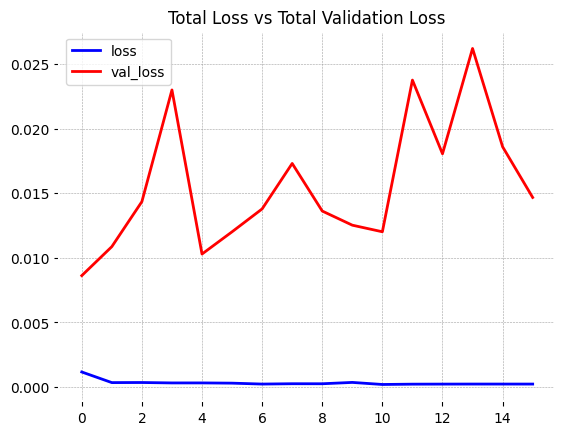

In [ ]:
# Plot Total Loss vs Total Validation Loss
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Model coded added before for testing, won't be available in this submission.
predicted_prices = model.predict(x_test)
predicted_prices = train_target_scaler.inverse_transform(predicted_prices)

12/12 [==============================] - 2s 7ms/step


In [ ]:
print(predicted_prices)

[[294.84772]
 [294.28964]
 [293.80658]
 [293.33255]
 [292.84192]
 [292.46866]
 [292.1164 ]
 [291.6222 ]
 [291.10504]
 [290.64114]
 [290.25983]
 [289.96005]
 [289.80524]
 [289.83447]
 [290.03152]
 [290.44583]
 [291.11377]
 [291.98087]
 [292.96283]
 [294.0732 ]
 [295.32193]
 [296.68634]
 [298.1393 ]
 [299.63266]
 [301.10184]
 [302.44135]
 [303.58932]
 [304.589  ]
 [305.4564 ]
 [306.2225 ]
 [306.88684]
 [307.47415]
 [307.97153]
 [308.35822]
 [308.70694]
 [309.03683]
 [309.32153]
 [309.47885]
 [309.46628]
 [309.30484]
 [308.99924]
 [308.58957]
 [308.07666]
 [307.4936 ]
 [306.87375]
 [306.19263]
 [305.34662]
 [304.38538]
 [303.3042 ]
 [302.1379 ]
 [300.87503]
 [299.4767 ]
 [298.02637]
 [296.5811 ]
 [295.05402]
 [293.4787 ]
 [291.876  ]
 [290.1757 ]
 [288.4117 ]
 [286.69394]
 [285.04352]
 [283.46652]
 [282.05365]
 [280.69623]
 [279.4829 ]
 [278.37985]
 [277.4615 ]
 [276.66763]
 [275.94174]
 [275.1935 ]
 [274.43073]
 [273.61395]
 [272.71515]
 [271.83316]
 [270.99005]
 [270.27286]
 [269.5981 ]

In [ ]:
print(type(train_data))
print(type(test_data))
print(type(predicted_prices))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [ ]:
def plot_candlestick_predicted(input_df, predicted_prices, n=1):
    # Work with a deep copy to avoid modifying the original dataframe
    input_df = input_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        input_df = input_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    # Add moving averages to the dataframe
    input_df['MA50'] = input_df[price_value].rolling(window=50).mean()
    input_df['MA100'] = input_df[price_value].rolling(window=100).mean()
    input_df['MA200'] = input_df[price_value].rolling(window=200).mean()

    # Convert the index to a DatetimeIndex
    input_df.index = pd.to_datetime(input_df.index)

    # Plot the last the last predicted candles
    df_plot = input_df[-len(predicted_prices):].copy()

    # Add Predicted Prices
    # Check if predicted_prices is 2D and reshape if necessary
    if predicted_prices.ndim == 2:
        predicted_prices = predicted_prices.reshape(-1)

    # Ensure the length of predicted_prices
    # matches the length of the sliced portion of the DataFrame
    if len(predicted_prices) > len(df_plot):
        predicted_prices = predicted_prices[-len(df_plot):]  # Take only the last predictions
    elif len(predicted_prices) < len(df_plot):
        print(f"Length mismatch: predicted_prices has length {len(predicted_prices)} but df_plot has length {len(df_plot)}")
        # Align the predictions to the end of df_plot
        start_idx = len(df_plot) - len(predicted_prices)
        df_plot = df_plot[start_idx:].copy()

    df_plot['Predicted'] = predicted_prices

    # Create a custom plot for the predicted prices
    ap = []
    if input_df['MA50'].dropna().shape[0] > 0:
        aligned_MA50 = input_df['MA50'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA50, color='orange'))
    if input_df['MA100'].dropna().shape[0] > 0:
        aligned_MA100 = input_df['MA100'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA100, color='green'))
    if input_df['MA200'].dropna().shape[0] > 0:
        aligned_MA200 = input_df['MA200'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA200, color='magenta'))

    ap.append(mpf.make_addplot(df_plot['Predicted'], color='red', linestyle='dashed'))

    # Plot the candlestick chart
    mpf.plot(df_plot, type='candle', style='charles',
             title=f"{ticker}Candlestick Chart",
             ylabel='Price',
             volume=False,
             addplot=ap,
             show_nontrading=False)

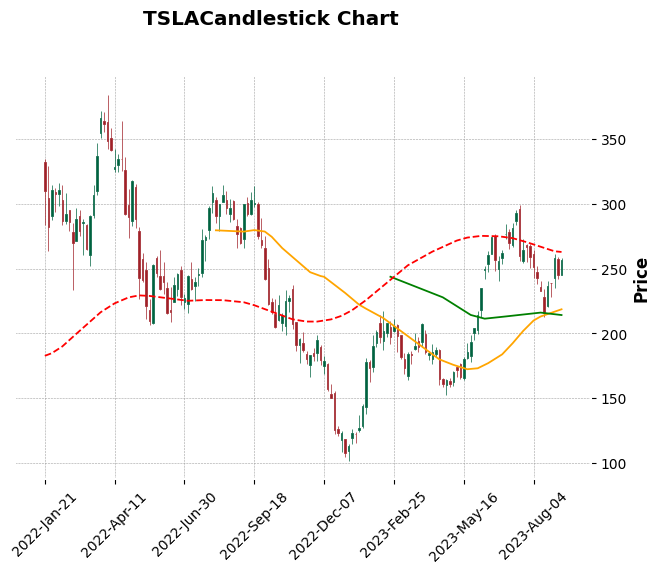

In [ ]:
plot_candlestick_predicted(test_data, predicted_prices, n=4)

In [ ]:
def plot_candlestick_full(train_df, test_df, predicted_prices, n=1):
    # Create deep copies to avoid modifying the original dataframes
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        train_df = train_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

        test_df = test_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

        if train_df.empty or test_df.empty:
          raise ValueError("Resampling resulted in an empty DataFrame. Try a smaller value of n.")

        # Adjust the length of predicted_prices to match test_df
        eff_length = len(test_df)
        predicted_prices = predicted_prices[-eff_length:]

    # Compute moving averages for the training data
    train_df['MA50'] = train_df[price_value].rolling(window=50).mean()
    train_df['MA100'] = train_df[price_value].rolling(window=100).mean()
    train_df['MA200'] = train_df[price_value].rolling(window=200).mean()

    # Compute moving averages for the test data
    test_df['MA50'] = test_df[price_value].rolling(window=50).mean()
    test_df['MA100'] = test_df[price_value].rolling(window=100).mean()
    test_df['MA200'] = test_df[price_value].rolling(window=200).mean()

    # Check if predicted_prices is 2D and reshape if necessary
    if predicted_prices.ndim == 2:
        predicted_prices = predicted_prices.reshape(-1)

    # Ensure the length of predicted_prices matches the length of the test data
    if len(predicted_prices) != len(test_df):
        raise ValueError(f"Length mismatch: predicted_prices has length {len(predicted_prices)} but test_df has length {len(test_df)}")

    # Add predicted prices to the test dataframe
    test_df['Predicted'] = predicted_prices

    # Concatenate train and test dataframes to form a complete dataframe for plotting
    df_plot = pd.concat([train_df, test_df])

    # Convert the index to a DatetimeIndex
    df_plot.index = pd.to_datetime(df_plot.index)

    # Create a custom plot for the predicted prices and moving averages
    ap = []
    if df_plot['MA50'].dropna().shape[0] > 0:
        aligned_MA50 = df_plot['MA50'].dropna().reindex(df_plot.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA50, color='orange'))

    if df_plot['MA100'].dropna().shape[0] > 0:
        aligned_MA100 = df_plot['MA100'].dropna().reindex(df_plot.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA100, color='green'))

    if df_plot['MA200'].dropna().shape[0] > 0:
        aligned_MA200 = df_plot['MA200'].dropna().reindex(df_plot.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA200, color='magenta'))

    ap.append(mpf.make_addplot(df_plot['Predicted'], color='red', linestyle='dashed'))

    # Plot the candlestick chart
    mpf.plot(df_plot, type='candle', style='charles',
            title=f"{ticker} Candlestick Chart",
            ylabel='Price',
            volume=False,
            addplot=ap,
            show_nontrading=False)


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


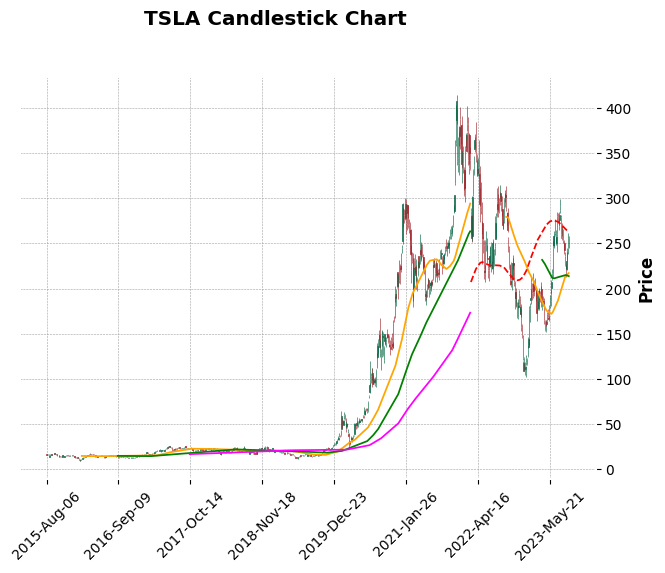

In [ ]:
# Truncate or slice test_df to match the length of predicted_prices
truncated_test_data = test_data.iloc[-len(predicted_prices):]
plot_candlestick_full(train_data,truncated_test_data, predicted_prices, n=4)